In [1]:
import semicon
from semicon.misc import prettify

In [2]:
import scipy
scipy.__version__

'1.2.0.dev0+10233db'

In [3]:
import kwant

import numpy as np
import sympy
sympy.init_printing(print_builtin=False)

# proof of concept

* R rotation from x, y, z to x', y', z'
* n corresponding rotation vector
* primed coordinates: crystalographic axes (Hamiltionian is defined in this coordinates)
* non-primed coordinates: simulation coordinate system

Coordinate transformation:

$
\begin{pmatrix}
x^\prime \\
y^\prime \\
z^\prime \\
\end{pmatrix}
= R
\begin{pmatrix}
x \\
y \\
z \\
\end{pmatrix}
$

with corresponding unitary part:
$
U = \exp(\textrm{i} \, \vec{n} \cdot \vec{S})
$

## test Hamiltonian

In [4]:
tmp = "alpha_{0} * k_{0} * sigma_{0}"
sx, sy, sz = sympy.symbols('sigma_x sigma_y sigma_z')

ham1 = kwant.continuum.sympify(
    " + ".join(tmp.format(s) for s in ['x', 'y', 'z']),
    locals={'sigma_x': sx, 'sigma_y': sy, 'sigma_z': sz}

)

ham2 = kwant.continuum.sympify(" + ".join(tmp.format(s) for s in ['x', 'y', 'z']))

In [5]:
ham1

In [6]:
ham2

⎡     α_z⋅k_z       αₓ⋅kₓ - ⅈ⋅α_y⋅k_y⎤
⎢                                    ⎥
⎣αₓ⋅kₓ + ⅈ⋅α_y⋅k_y      -α_z⋅k_z     ⎦

## Define rotation

In [7]:
import scipy.linalg as la
from scipy.spatial.transform import Rotation


def tmp_rotate(expr, R):
    def rotation_subs(R, v):
        return {cprime: c for (cprime, c) in zip(v, R @ v)}

    subs = rotation_subs(R, sympy.Matrix(kwant.continuum.momentum_operators))
    subs.update(rotation_subs(R, sympy.Matrix([sx, sy, sz])))

    return expr.subs(subs, simultaneous=True).expand()


In [8]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

spin_operators = [sigma_x / 2, sigma_y / 2, sigma_z / 2]


R = np.array([[0, -1, 0],
              [+1, 0, 0],
              [0, 0, 1]])

n = Rotation.from_dcm(R).as_rotvec()

ns = np.sum([ni * si for (ni, si) in zip(n, spin_operators)], axis=0)
U = la.expm(1j * ns)

In [9]:
la.det(R)

1.0

## apply test rotation 1

In [10]:
s = tmp_rotate(ham1, R); s

## apply test rotation 2

In [11]:
t = tmp_rotate(ham2, R); t

⎡     α_z⋅k_z        -αₓ⋅k_y - ⅈ⋅α_y⋅kₓ⎤
⎢                                      ⎥
⎣-αₓ⋅k_y + ⅈ⋅α_y⋅kₓ       -α_z⋅k_z     ⎦

In [12]:
t = prettify(U @ t @ U.transpose().conjugate(), decimals=12); t

⎡       1.0⋅α_z⋅k_z         -1.0⋅ⅈ⋅αₓ⋅k_y + 1.0⋅α_y⋅kₓ⎤
⎢                                                     ⎥
⎣1.0⋅ⅈ⋅αₓ⋅k_y + 1.0⋅α_y⋅kₓ         -1.0⋅α_z⋅k_z       ⎦

## test 

In [13]:

sympy.expand(kwant.continuum.sympify(str(s)) - t)

⎡0  0⎤
⎢    ⎥
⎣0  0⎦

## test with implemented functions

In [14]:
S = kwant.continuum.sympify("[[sigma_x, sigma_y, sigma_z]]") / 2

t = semicon.misc.rotate(ham2, R, spin_operators=S)
t = semicon.misc.prettify(t, decimals=12); t

⎡       1.0⋅α_z⋅k_z         -1.0⋅ⅈ⋅αₓ⋅k_y + 1.0⋅α_y⋅kₓ⎤
⎢                                                     ⎥
⎣1.0⋅ⅈ⋅αₓ⋅k_y + 1.0⋅α_y⋅kₓ         -1.0⋅α_z⋅k_z       ⎦

In [15]:
semicon.misc.prettify(sympy.expand(kwant.continuum.sympify(str(s)) - t), decimals=12)

⎡0  0⎤
⎢    ⎥
⎣0  0⎦

In [16]:
from semicon.model import BulkModel
model = BulkModel(ham2, spins=1/2)
model = model.rotate(R).prettify(decimals=12)

In [17]:
model.hamiltonian

⎡       1.0⋅α_z⋅k_z         -1.0⋅ⅈ⋅αₓ⋅k_y + 1.0⋅α_y⋅kₓ⎤
⎢                                                     ⎥
⎣1.0⋅ⅈ⋅αₓ⋅k_y + 1.0⋅α_y⋅kₓ         -1.0⋅α_z⋅k_z       ⎦

In [18]:
semicon.misc.prettify(sympy.expand(kwant.continuum.sympify(str(s)) - model.hamiltonian), 
                      decimals=12)

⎡0  0⎤
⎢    ⎥
⎣0  0⎦

# on kp ham

In [19]:
def rotation110_matrix(xi='0'):
    sin = sympy.sin(xi)
    cos = sympy.cos(xi)
    sqrt2 = sympy.sqrt(2)
    matrix = sympy.Matrix([[+ sin / sqrt2, + cos / sqrt2, 1 / sqrt2],
                           [- sin / sqrt2, - cos / sqrt2, 1 / sqrt2],
                           [cos, - sin, 0]])
    return matrix

R = rotation110_matrix(xi="pi/4")

In [20]:
R

⎡            √2⎤
⎢1/2   1/2   ──⎥
⎢            2 ⎥
⎢              ⎥
⎢            √2⎥
⎢-1/2  -1/2  ──⎥
⎢            2 ⎥
⎢              ⎥
⎢ √2   -√2     ⎥
⎢ ──   ────  0 ⎥
⎣ 2     2      ⎦

In [18]:
import semicon

bands = ('gamma_8v', )
kpham = semicon.models.foreman(bands=bands)
S = semicon.models.spin_operators(bands=bands)
ham = semicon.models.rotate(kpham, R, S)

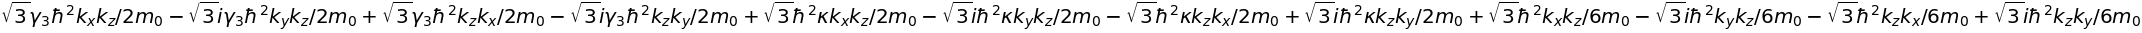

In [19]:
kpham[0, 1]

In [20]:
e = ham[0, 1]

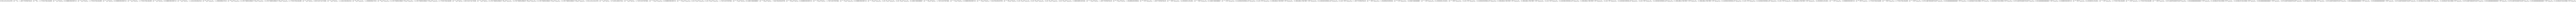

In [21]:
e

In [22]:
prettify(e, zero_atol=1e-8)

In [23]:
prettify(e, decimals=12)

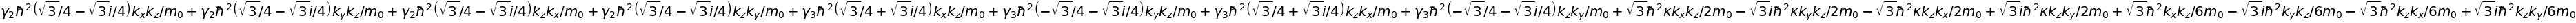

In [24]:
prettify(e, zero_atol=1e-8, nsimplify=True)

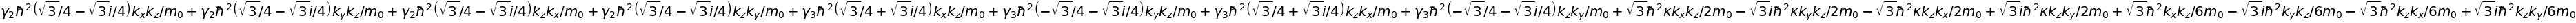

In [25]:
prettify(e, decimals=12, nsimplify=True)

# spin matrices

In [18]:
import numpy as np

def spin_matrices(s):
    """Construct spin-s matrices for any spin."""
    d = np.round(2*s + 1)
    if not np.isclose(d, int(d)):
        raise ValueError("Argument 's' must be integer or half integer.")
    d = int(d)
    Sz = 1/2 * np.diag(np.arange(d - 1, -d, -2))
    # first diagonal for general s from en.wikipedia.org/wiki/Spin_(physics)
    diag = [(1 / 2) * np.sqrt(2 * i * (s + 1) - i * (i + 1)) for i in np.arange(1, d)]
    Sx = np.diag(diag, k=1) + np.diag(diag, k=-1)
    Sy = -1j * np.diag(diag, k=1) + 1j * np.diag(diag, k=-1)
    return Sx, Sy, Sz


In [19]:
spin_matrices(1/2)

(array([[0. , 0.5],
        [0.5, 0. ]]), array([[0.+0.j , 0.-0.5j],
        [0.+0.5j, 0.+0.j ]]), array([[ 0.5,  0. ],
        [ 0. , -0.5]]))

In [44]:
[prettify(sympy.Matrix(s), nsimplify=True) for s in spin_matrices(1/2)]

⎡            ⎡   -ⅈ ⎤             ⎤
⎢            ⎢0  ───⎥             ⎥
⎢⎡ 0   1/2⎤  ⎢    2 ⎥  ⎡1/2   0  ⎤⎥
⎢⎢        ⎥, ⎢      ⎥, ⎢         ⎥⎥
⎢⎣1/2   0 ⎦  ⎢ⅈ     ⎥  ⎣ 0   -1/2⎦⎥
⎢            ⎢─   0 ⎥             ⎥
⎣            ⎣2     ⎦             ⎦

In [41]:
semicon.models.spin_operators(bands=['gamma_6c'])

⎡            ⎡   -ⅈ ⎤             ⎤
⎢            ⎢0  ───⎥             ⎥
⎢⎡ 0   1/2⎤  ⎢    2 ⎥  ⎡1/2   0  ⎤⎥
⎢⎢        ⎥, ⎢      ⎥, ⎢         ⎥⎥
⎢⎣1/2   0 ⎦  ⎢ⅈ     ⎥  ⎣ 0   -1/2⎦⎥
⎢            ⎢─   0 ⎥             ⎥
⎣            ⎣2     ⎦             ⎦

In [46]:
np.sign(-1)

-1

In [70]:
rotation_subs = lambda R, v: {cprime: c for (cprime, c) in zip(v, R @ v)}

In [82]:
momentum = kwant.continuum.momentum_operators
position = kwant.continuum.position_operators

In [83]:
act_on = np.atleast_2d([momentum, position])

In [92]:
subs = {}
for row in act_on:
    new_subs = rotation_subs(R, sympy.Matrix(row))
    subs.update(new_subs)

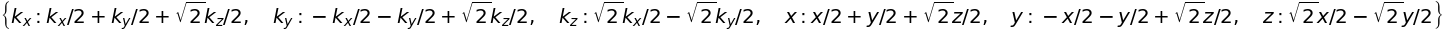

In [93]:
subs

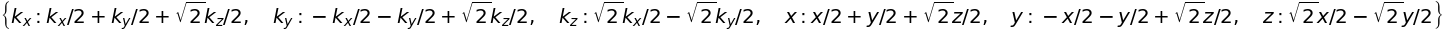

In [89]:
{k: v 
 for row in act_on
 for k, v in .items()
 }

In [56]:
kwant.continuum.sympify('[k_x, k_y, k_z]')

sympy.matrices.dense.MutableDenseMatrix

In [53]:
from semicon.kp_models.symbols import momentum_symbols

In [59]:
sympy.Matrix(momentum_symbols)

⎡kₓ ⎤
⎢   ⎥
⎢k_y⎥
⎢   ⎥
⎣k_z⎦

In [68]:
np.atleast_2d(kwant.continuum.momentum_operators)

array([[k_x, k_y, k_z]], dtype=object)

In [75]:
for row in np.atleast_2d([[1, 2, 3], [2, 3, 5]]):
    print(row)

[1 2 3]
[2 3 5]


In [62]:
np.atleast_2d(sympy.Matrix(kwant.continuum.momentum_operators))

array([[k_x],
       [k_y],
       [k_z]], dtype=object)